## W17D1 - Machine Learning Algorithms

### Import Libraries and Clean Data:

In [19]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np

# data = pd.read_json('AlaskaWeather.json')
# data.head()

# load the JSON data
with open('AlaskaWeather.json', 'r') as file:
    data = json.load(file)

# keep only the forecast
forecast_days = data['forecast']['forecast']
temperature_data = []

# extracgt data through loop
for day in forecast_days:
    date = day['date']
    avgtemp_f = day['day']['avgtemp_f']
    temperature_data.append({'date': date, 'avgtemp_f': avgtemp_f})

df = pd.DataFrame(temperature_data)

# sort by date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

# check df
print(df)

         date  avgtemp_f
35 2024-11-10        4.9
36 2024-11-11        3.7
37 2024-11-12        4.2
38 2024-11-13        0.5
39 2024-11-14       -4.4
..        ...        ...
30 2025-01-11       19.0
31 2025-01-12       28.1
32 2025-01-13       19.0
33 2025-01-14       16.5
34 2025-01-15      -11.3

[70 rows x 2 columns]


### Visualize the last few days in a graph

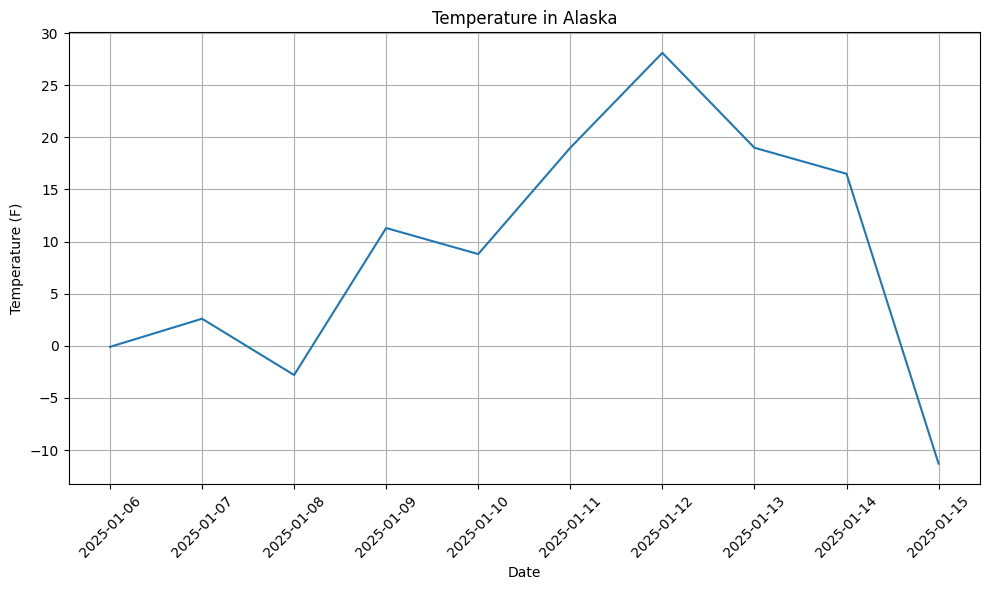

In [20]:
last_few_days = df.tail(10)

plt.figure(figsize=(10, 6))
sns.lineplot(data=last_few_days, x='date', y='avgtemp_f', markers=True, dashes=False)
plt.title('Temperature in Alaska')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Build k-NN model

In [22]:

# prepar the features and target variable
df['day_of_year'] = df['date'].dt.dayofyear
X = df[['day_of_year']]
y =df['avgtemp_f']

# split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# find the best k through a for loop
best_mse = float('inf')
for k in range(1,21):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    prediction = knn.predict(X_test)
    mse = mean_squared_error(y_test, prediction)
    if mse < best_mse:
        best_mse = mse
        best_k = k

# check results
print(f'Best k: {best_k}')
print(f'Best MSE: {best_mse}')

knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(X_train, y_train)

# predict the train instances
prediction = knn.predict(X_test)
mse = mean_squared_error(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)
r2 = r2_score(y_test, prediction)
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

# display df that shows closeness of prediction to actual
comparison_df = pd.DataFrame({
    'day_of_year': X_test['day_of_year'],
    'True avgtemp_f': y_test,
    'Predicted avgtemp_f': prediction
})

print(comparison_df)


Best k: 2
Best MSE: 25.45678571428572
MSE: 25.45678571428572
MAE: 4.4071428571428575
R2: 0.8638738813212189
    day_of_year  True avgtemp_f  Predicted avgtemp_f
57          337           -14.3               -12.65
35          315             4.9                 3.95
14          361            -7.5                -1.15
39          319            -4.4                 3.20
19          366           -19.1               -22.60
53          333           -26.9               -18.35
45          325             5.0                -1.50
0           347            13.1                13.20
10          357             2.5                -3.20
47          327             6.7                 9.20
66          346            19.8                15.20
44          324           -12.5                -8.35
32           13            19.0                22.30
40          320             8.4                 2.15


### Use Model to make predictions

C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


The predicted temperature for the next day is : 2.60 degrees (f)


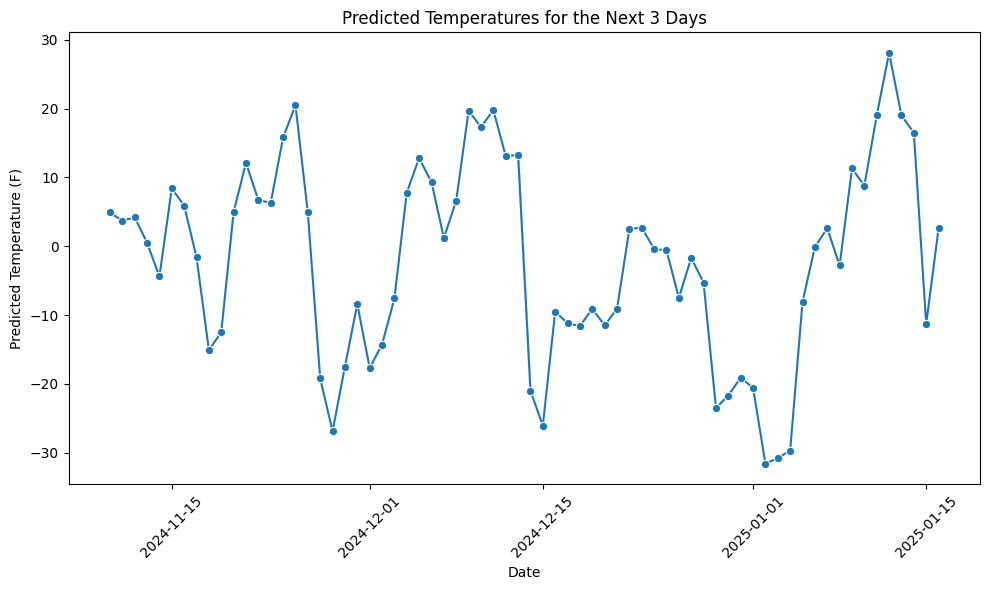

In [23]:
# predict the temps for next day
# I had thought we were suppose to find the temps for the next week. I got confused and got lost in the code. I will figure out what to keep later
future_days = 1
cutoff_date = pd.to_datetime('2025-01-15')
last_day = cutoff_date.dayofyear
future_day_of_year = np.array([last_day + i for i in range(1, future_days + 1)]).reshape(-1,1)
predictions = knn.predict(future_day_of_year)

# create df for predictions
future_dates = pd.date_range(start= cutoff_date + pd.Timedelta(days=1), periods=future_days)
pred_df = pd.DataFrame({'date': future_dates, 'avgtemp_f': predictions})
print(f'The predicted temperature for the next day is : {pred_df['avgtemp_f'].values[0]:.2f} degrees (f)')

# combine prediction with original
combined = pd.concat([df[['date', 'avgtemp_f']], pred_df])

# plot
plt.figure(figsize=(10,6))
sns.lineplot(x='date', y='avgtemp_f', data=combined, marker='o')

plt.title('Predicted Temperatures for the Next 3 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Temperature (F)')
plt.xticks(rotation=45)

plt.tight_layout()

plt.show()


